In [1]:
%matplotlib notebook
import os
import numpy as np
import chaospy as cp
import pandas as pd
import seaborn as sns
import itertools
import pickle
from numpy import linalg as LA
from matplotlib import pyplot as plt,cm
from mpl_toolkits.mplot3d import Axes3D
from matplotlib.colors import LogNorm
from statsmodels.distributions.empirical_distribution import ECDF
from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.gaussian_process.kernels import (RBF, Matern, RationalQuadratic,
                                              ExpSineSquared, DotProduct,
                                              ConstantKernel,WhiteKernel)
pltlinestyles = [ (0, (1, 5)),(0, (3, 5, 1, 5)),(0, (5, 5)),(0, ()), (0, (3, 1, 1, 1, 1, 1)), 
        (0, (5, 10)), (0, (3, 10, 1, 10)), (0, (3, 10, 1, 10, 1, 10)),(0, (1, 10)), 
        (0, (5, 1)),  (0, (3, 1, 1, 1)),(0, (3, 5, 1, 5, 1, 5)),  (0, (1, 1))  ]*10

pltmarkers =['o','v','s','d','+','*']
ordinal = lambda n: "%d%s" % (n,"tsnrhtdd"[(math.floor(n/10)%10!=1)*(n%10<4)*n%10::4])
pltcolors = plt.rcParams['axes.prop_cycle'].by_key()['color']
figsize = (4*1.5,3*1.5)
pf = 1e-4

In [2]:
MODEL_NAME      = 'Bench4'
WORKING_DIR     = os.getcwd()
MODEL_DIR       = os.path.join(WORKING_DIR, MODEL_NAME)
MODEL_DIR_DATA  = os.path.join(MODEL_DIR,r'Data')
MODEL_DIR_FIGURE= os.path.join(MODEL_DIR,r'Figures')

class Ecdf2plot: 
    def __init__(self, x, y):
        self.x = x
        self.y = y

In [3]:
class ErrorType():
    def __init__(self, name=None, params=(),size=None):
        self.name = name
        self.params = params
        self.size = None

In [4]:
def gen_error(error_type):
    """
    Generate error samples from specified process 

    Arguments:
        size : int or tuple of ints, optional
            -- Output shape:
            If the given shape is, e.g., (m, n, k), then m * n * k samples are drawn. 
            If size is None (default), a single value is returned if loc and scale are both scalars. 
            Otherwise, np.broadcast(loc, scale).size samples are drawn.
        error_type: ErrorType instance
            .name: error distribution name
            .params: float or array_like of floats
    """
    if error_type.name is None:
        samples = 0
    elif error_type.name.upper() == 'NORMAL':
        mu, sigma = error_type.params if error_type.params else (0.0, 1.0)
        samples = np.random.normal(loc=mu,scale=sigma, size=error_type.size) 
    elif error_type.name.upper() == 'GUMBEL':
        loc, scale = error_type.params if error_type.params else (0.0, 1.0)
        samples = np.random.gumbel(loc,scale,size=error_type.size)
    elif error_type.name.upper() == 'WEIBULL':
        shape, scale = error_type.params if error_type.params else (1.0, 1.0)
        samples = scale * np.random.weibull(shape, size=error_type.size)
    else:
        raise NotImplementedError
    return samples
    


## List of Benchmark problems

### 1. Polynomial functions 

\begin{equation}
\begin{aligned}
    f(x) &= 0.1 + 0.5x + 0.03x^2 -0.016x^3 + 0.001x^4 + \epsilon \\
    \epsilon &\sim p(\epsilon), \mathbb{E}[\epsilon] = 0, \mathrm{Var}[\epsilon] = \frac{1}{5}|f(x)|
\end{aligned}
\end{equation}

#### (I): Noise free case

#### Fit model

In [29]:
x_fix = np.linspace(-5,15,1000)[np.newaxis, :]
metamodel_class, metamodel_basis= ['PCE', [2,3,4]]

(1000, 1) (1000, 1)


<IPython.core.display.Javascript object>


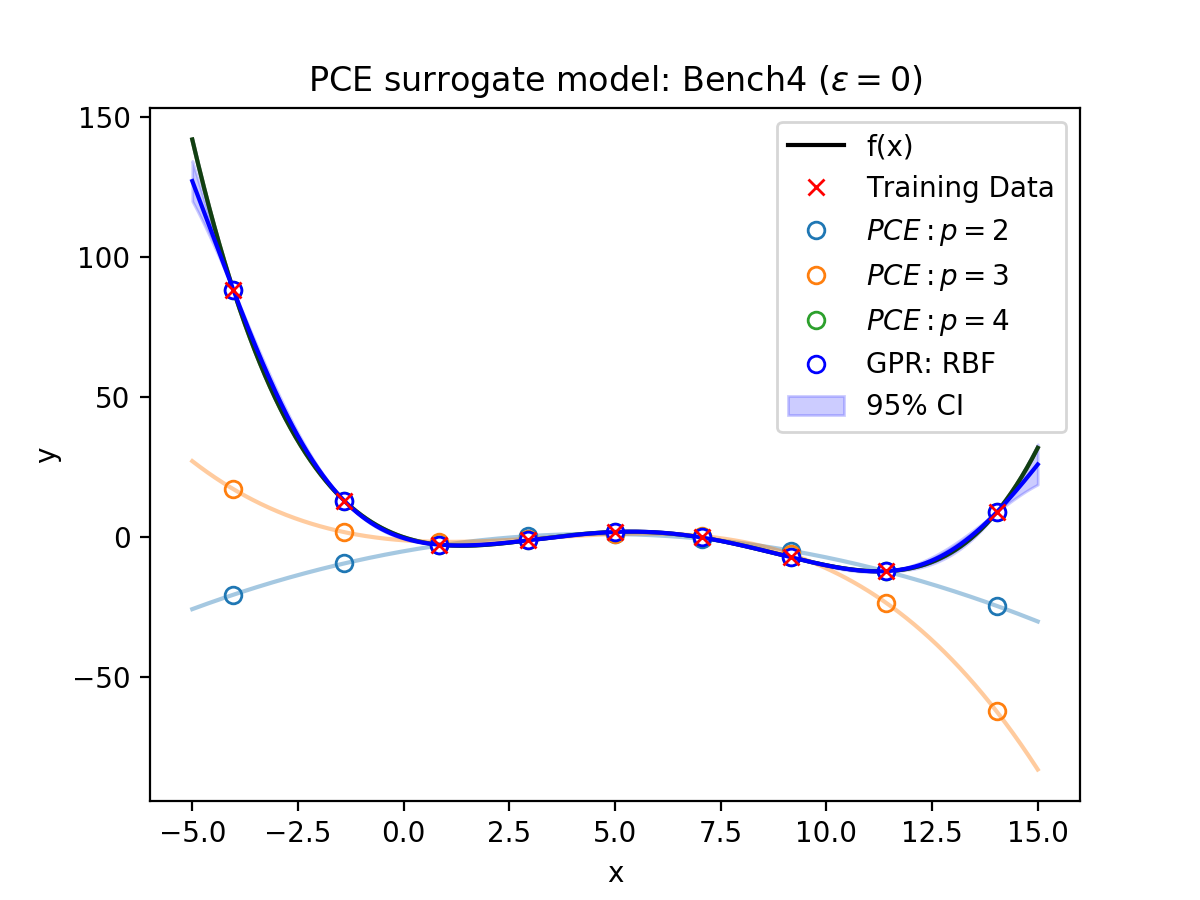

5
(3, 1000)


In [30]:
data_set = np.load(os.path.join(MODEL_DIR_DATA,'Noise_free',r'True_domain_FIX_DoE_fix0.npy'))
x,y = data_set[0].T,data_set[1].T
# print(data_set[0].shape, data_set[1].shape)
print(x.shape, y.shape)
fig1 = plt.figure(figsize=figsize)
ax1 = fig1.add_subplot(1,1,1)
ax1.plot(x,y,'k',label=r'f(x)')
data_set = np.load(os.path.join(MODEL_DIR_DATA,'Noise_free',r'Train_Quadrature_hermite_PCE_doe0.npy'))
print(len(data_set))
x_train    = data_set[0][0]
x_weight   = data_set[0][1]
y_train    = data_set[1]
zeta_train = data_set[2][0]
y_validate = data_set[3]
y_fix      = data_set[4]
print(y_fix.shape)
ax1.plot(x_train.T,y_train.T,'rx',zorder=9, label=r'Training Data')

for i, imetamodel_basis in enumerate(metamodel_basis):
    ax1.plot(x_train.T,y_validate.T[:,i],'o',
             markeredgecolor=pltcolors[i], markerfacecolor='w',
             label=r'$PCE: p={:d}$'.format(imetamodel_basis))
    ax1.plot(x_fix.T,y_fix.T[:,i],'-',color=pltcolors[i],alpha=0.4)

ax1.set_xlabel('x')
ax1.set_ylabel('y')
ax1.set_title(r'{} surrogate model: {} $(\epsilon=0)$'.format(metamodel_class,MODEL_NAME))
ax1.legend()
fig1.savefig(os.path.join(MODEL_DIR_FIGURE, r'{}_DoE0.pdf'.format(metamodel_class)))


In [31]:
metamodel_class, metamodel_basis = ['PCE', ['RBF']]
data_set = np.load(os.path.join(MODEL_DIR_DATA,'Noise_free',r'DoE_Quadrature_hermite_train_GPR0.npy'))
print(len(data_set))
x_train    = np.squeeze(data_set[0][0])
x_weight   = np.squeeze(data_set[0][1])
y_train    = np.squeeze(data_set[1])
zeta_train = np.squeeze(data_set[2][0])
y_validate = np.squeeze(data_set[3][0,:])
y_valid_std= np.squeeze(data_set[3][1,:])
x_test     = np.squeeze(data_set[4])
y_test_mean= np.squeeze(data_set[6][0,:])
y_test_std = np.squeeze(data_set[6][1,:])
print(data_set[3].shape)
print(x_train.shape,y_validate.shape)

ax1.plot(x_train,y_validate,'o', markeredgecolor='b', markerfacecolor='w', label=r'GPR: RBF')

ax1.plot(x_test,y_test_mean,'-', color='b')
ax1.fill_between(x_test, y_test_mean - 1.96*y_test_std, y_test_mean + 1.96*y_test_std,
                 color='b',alpha=0.2,edgecolor='None',label='95% CI')
ax1.legend()
# ax.xlabel('x')
# plt.ylabel('y')
# plt.title(r'{} surrogate model: {} $(\epsilon=0)$'.format(metamodel_class,MODEL_NAME))
fig1.savefig(os.path.join(MODEL_DIR_FIGURE, r'{}PCE_DoE0.pdf'.format(metamodel_class)))

7
(2, 9)
(9,) (9,)


#### Exceedance plot

In [17]:
windowlength2plot    = 1000

# Emperial CDF for true model with MCS

true_y_mcs_ecdf      = [] 
true_y_mcs_ecdf2plot = [] 
for r in range(10):
    data_set = np.load(os.path.join(MODEL_DIR_DATA,'Noise_free',r'True_MCS_R_DoE{}.npy'.format(r)))
    ture_x_mcs    = data_set[0][0]
    true_y_mcs    = data_set[1]
    true_zeta_mcs = data_set[2][0]
    iecdf = ECDF(np.squeeze(true_y_mcs))
    true_y_mcs_ecdf.append(iecdf)
    
    indx1 = np.linspace(0,len(iecdf.x)-windowlength2plot, windowlength2plot, dtype=np.int32)
    indx2 = np.arange(indx1[-1]+1,len(iecdf.x),dtype=np.int32)
    indx  = np.hstack((indx1,indx2))
    true_y_mcs_ecdf2plot.append(Ecdf2plot(iecdf.x[indx],iecdf.y[indx]))
#     print(np.round(true_zeta_mcs[:5],4))
    
#     metamodel_zeta_mcs = data_set[2]
    



In [19]:
# Emperial CDF for PCE Surrogate model with MCS
metamodel_class, metamodel_basis= ['PCE', [2,3,4]]
pce_y_mcs_ecdf = [[] for _ in range(len(metamodel_basis))] 
pce_y_mcs_ecdf2plot = [[] for _ in range(len(metamodel_basis))]

for r in range(10):
    data_set = np.load(os.path.join(MODEL_DIR_DATA,'Noise_free',r'metamodels_PCE_DoE0_MCS{}.npy'.format(r)))
    zeta_mcs = data_set[0]
    y_mcs    = data_set[1]
    for i, imetamodel_y_mcs in enumerate(y_mcs):
        iecdf = ECDF(np.squeeze(imetamodel_y_mcs))
        pce_y_mcs_ecdf[i].append(iecdf)
        
        indx1 = np.linspace(0,len(iecdf.x)-windowlength2plot, windowlength2plot, dtype=np.int32)
        indx2 = np.arange(indx1[-1]+1,len(iecdf.x),dtype=np.int32)
        indx  = np.hstack((indx1,indx2))
        pce_y_mcs_ecdf2plot[i].append(Ecdf2plot(iecdf.x[indx],iecdf.y[indx]))
   


<IPython.core.display.Javascript object>


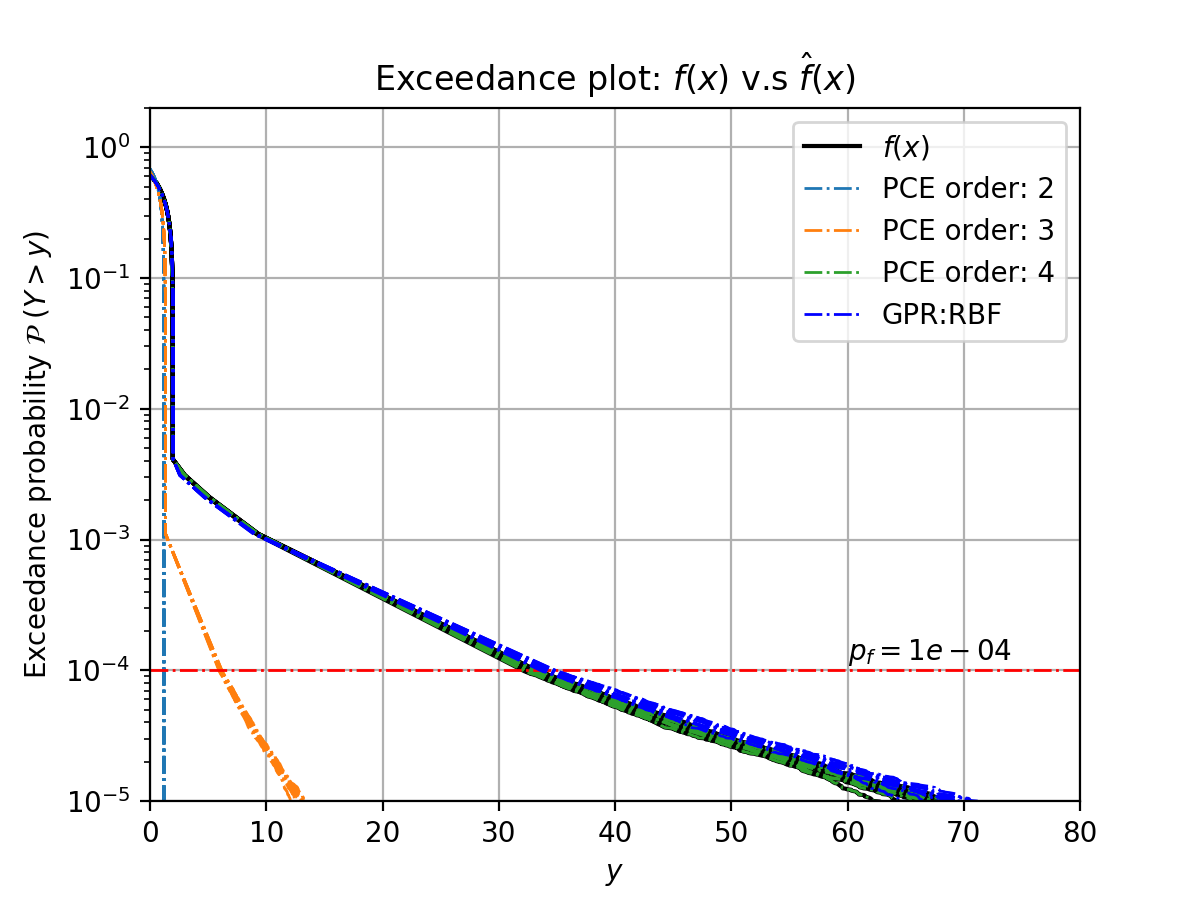

0
1
2


In [26]:
# Exceedance plot
metamodel_class, metamodel_basis= ['PCE', [2,3,4]]
label_added =False
fig2 = plt.figure(figsize=figsize)
ax2 = fig2.add_subplot(1,1,1)
# Ture model emperical exceedance plot with mcs results
for iecdf2plot in true_y_mcs_ecdf2plot:
    if not label_added:
        ax2.semilogy(iecdf2plot.x, 1-iecdf2plot.y,'k', label=r'$f(x)$')
        label_added =True
    else:
        ax2.semilogy(iecdf2plot.x, 1-iecdf2plot.y,'k')    
    
# i = 0
for i, imetamodel_ecdfs in enumerate(pce_y_mcs_ecdf2plot):
    print(i)
    label_added =False
    for iecdf2plot in imetamodel_ecdfs:
        if not label_added:
            ax2.semilogy(iecdf2plot.x, 1-iecdf2plot.y,'-.',color=pltcolors[i],linewidth=1, label=r'PCE order: {}'.format(metamodel_basis[i]))
            label_added =True
        else:
            ax2.semilogy(iecdf2plot.x, 1-iecdf2plot.y,'-.',color=pltcolors[i],linewidth=1)
#     i+=1
#     print(i)
        
# plt.semilogy(ecdf_y.x,1-ecdf_y.y, 'k',label=r'exact')
# plt.semilogy(ecdf_y_norm.x,1-ecdf_y_norm.y, '-.r',label=r'normal error')
# print(ecdf_y_pce)
# for iecdf in ecdf_y_pce:
ax2.set_xlim(0,80)
ax2.set_ylim(1e-5,2)
xmin, xmax = ax2.get_xlim()
ymin, ymax = ax2.get_ylim()
ax2.plot([xmin,xmax],[pf,pf],'-.r',linewidth=1)
ax2.text(60,pf*1.2,r'$p_f={:.0e}$'.format(pf))

ax2.set_xlabel(r'$y$')
ax2.set_ylabel(r'Exceedance probability $\mathcal{P}\;(Y>y)$')
ax2.set_title(r'Exceedance plot: $f(x)$ v.s $\hat{f}(x)$')
plt.legend()
plt.grid()
plt.savefig(os.path.join(MODEL_DIR_FIGURE, r'ExceedancePlot_{}_DoE0.pdf'.format(metamodel_class)))


In [21]:
plt.savefig(os.path.join(MODEL_DIR_FIGURE, r'ExceedancePlot_{}_DoE0_zoomin.pdf'.format(metamodel_class)))


In [27]:
metamodel_class, metamodel_basis = ['PCE', ['RBF']]
gpr_y_mcs_ecdf = [] 
gpr_y_mcs_ecdf2plot = []
for r in range(10):
    data_set = np.load(os.path.join(MODEL_DIR_DATA,'Noise_free',r'metamodels_GPR_DoE0_MCS{}.npy'.format(r)))
#     print(data_set.shape)
    zeta_mcs = data_set[0]
    y_mcs    = data_set[1][0,:]

    iecdf = ECDF(np.squeeze(y_mcs))
    gpr_y_mcs_ecdf.append(iecdf)

    indx1 = np.linspace(0,len(iecdf.x)-windowlength2plot, windowlength2plot, dtype=np.int32)
    indx2 = np.arange(indx1[-1]+1,len(iecdf.x),dtype=np.int32)
    indx  = np.hstack((indx1,indx2))
    gpr_y_mcs_ecdf2plot.append(Ecdf2plot(iecdf.x[indx],iecdf.y[indx]))
   

In [28]:
metamodel_class, metamodel_basis = ['PCE', ['RBF']]
label_added =False    
for imetamodel_ecdfs in gpr_y_mcs_ecdf2plot:
    iecdf2plot = imetamodel_ecdfs
    if not label_added:
        ax2.semilogy(iecdf2plot.x, 1-iecdf2plot.y,'-.',color='b',linewidth=1, label=r'GPR:RBF')
        label_added =True
    else:
        ax2.semilogy(iecdf2plot.x, 1-iecdf2plot.y,'-.',color='b',linewidth=1)
#     print(i)
ax2.legend()
# ax2.grid()
fig2.savefig(os.path.join(MODEL_DIR_FIGURE, r'ExceedancePlot_{}PCE_DoE0.pdf'.format(metamodel_class)))

### 2   Benchmark 1

<IPython.core.display.Javascript object>


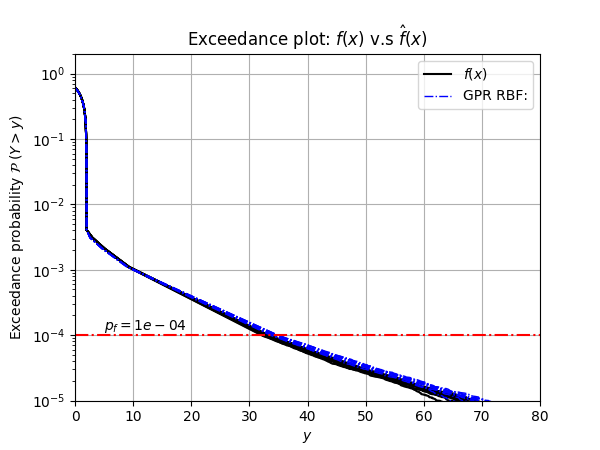

10


In [76]:
label_added =False
fig = plt.figure(figsize=(4*1.5,3*1.5))
ax = fig.add_subplot(1,1,1)
print(len(true_y_mcs_ecdf2plot))
for iecdf2plot in true_y_mcs_ecdf2plot:
    if not label_added:
        ax.semilogy(iecdf2plot.x, 1-iecdf2plot.y,'k', label=r'$f(x)$')
        label_added =True
    else:
        ax.semilogy(iecdf2plot.x, 1-iecdf2plot.y,'k')    
label_added =False    
for imetamodel_ecdfs in metamodel_y_gpr_mcs_ecdf2plot:
    iecdf2plot = imetamodel_ecdfs
   
    if not label_added:
        ax.semilogy(iecdf2plot.x, 1-iecdf2plot.y,'-.',color='b',linewidth=1, label=r'GPR RBF:')
        label_added =True
    else:
        ax.semilogy(iecdf2plot.x, 1-iecdf2plot.y,'-.',color='b',linewidth=1)
#     print(i)
        
# plt.semilogy(ecdf_y.x,1-ecdf_y.y, 'k',label=r'exact')
# plt.semilogy(ecdf_y_norm.x,1-ecdf_y_norm.y, '-.r',label=r'normal error')
# print(ecdf_y_pce)
# for iecdf in ecdf_y_pce:

ax.set_xlim(0,80)
ax.set_ylim(1e-5,2)
xmin, xmax = ax.get_xlim()
ymin, ymax = ax.get_ylim()
ax.plot([xmin,xmax],[pf,pf],'-.r')
ax.text(5,pf*1.2,r'$p_f={:.0e}$'.format(pf))

ax.set_xlabel(r'$y$')
ax.set_ylabel(r'Exceedance probability $\mathcal{P}\;(Y>y)$')
ax.set_title(r'Exceedance plot: $f(x)$ v.s $\hat{f}(x)$')
plt.legend()
plt.grid()
plt.savefig(os.path.join(MODEL_DIR_FIGURE, r'ExceedancePlot_{}_DoE0.pdf'.format(metamodel_class)))

<IPython.core.display.Javascript object>


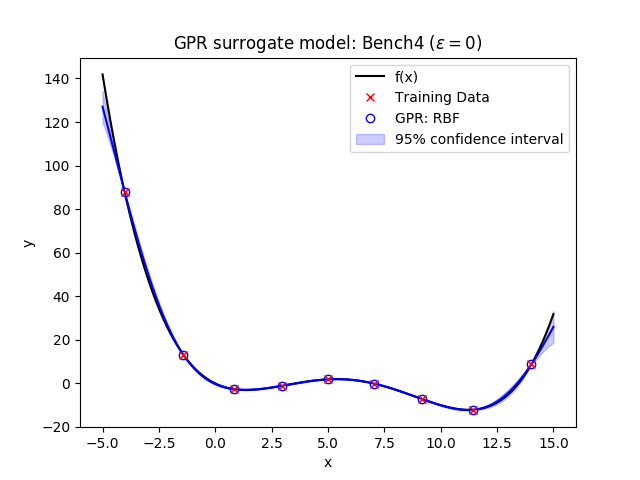

7
(2, 9)
(9,) (9,)


In [51]:
x_fix = np.linspace(-5,15,1000)[np.newaxis, :]
metamodel_class, metamodel_basis = ['GPR', 'RBF']

data_set = np.load(os.path.join(MODEL_DIR_DATA,'Noise_free',r'True_domain_FIX_DoE_fix0.npy'))
x,y = data_set[0].T,data_set[1].T
# print(data_set[0].shape, data_set[1].shape)
# print(x.shape, y.shape)
plt.figure()
plt.plot(x,y,'k',label=r'f(x)')
data_set = np.load(os.path.join(MODEL_DIR_DATA,'Noise_free',r'aDoE_Quadrature_hermite_train_GPR0.npy'))
print(len(data_set))
x_train    = np.squeeze(data_set[0][0])
x_weight   = np.squeeze(data_set[0][1])
y_train    = np.squeeze(data_set[1])
zeta_train = np.squeeze(data_set[2][0])
y_validate = np.squeeze(data_set[3][0,:])
y_valid_std= np.squeeze(data_set[3][1,:])
x_test     = np.squeeze(data_set[4])
y_test_mean= np.squeeze(data_set[6][0,:])
y_test_std = np.squeeze(data_set[6][1,:])
print(data_set[3].shape)
print(x_train.shape,y_validate.shape)
plt.plot(x_train,y_train,'rx',zorder=9, label=r'Training Data')

plt.plot(x_train,y_validate,'o', markeredgecolor='b', markerfacecolor='w', label=r'GPR: RBF')

plt.plot(x_test,y_test_mean,'-', color='b')
plt.fill_between(x_test, y_test_mean - 1.96*y_test_std, y_test_mean + 1.96*y_test_std,
                 color='b',alpha=0.2,edgecolor='None',label='95% confidence interval')
plt.legend()
plt.xlabel('x')
plt.ylabel('y')
plt.title(r'{} surrogate model: {} $(\epsilon=0)$'.format(metamodel_class,MODEL_NAME))
plt.savefig(os.path.join(MODEL_DIR_FIGURE, r'{}_DoE0.pdf'.format(metamodel_class)))

In [113]:
metamodel_y_mcs_ecdf = [[] for _ in range(len(metamodel_basis))] 
metamodel_y_mcs_ecdf2plot = [[] for _ in range(len(metamodel_basis))]
print(data_set.shape)
metamodel_zeta_mcs = data_set[:,0]
metamodel_y_mcs    = data_set[:,1]
print(metamodel_y_mcs[0].shape)

for metamodel_zeta_mcs_r in metamodel_zeta_mcs:
    for i, imetamodel_zeta_mcs in enumerate(metamodel_zeta_mcs_r):
        print(np.round(imetamodel_zeta_mcs[:5],4))

for metamodel_y_mcs_r in metamodel_y_mcs:
    for i, imetamodel_y_mcs in enumerate(metamodel_y_mcs_r):
        iecdf = ECDF(np.squeeze(imetamodel_y_mcs))
        metamodel_y_mcs_ecdf[i].append(iecdf)
        
        indx1 = np.linspace(0,len(iecdf.x)-windowlength2plot, windowlength2plot, dtype=np.int32)
        indx2 = np.arange(indx1[-1]+1,len(iecdf.x),dtype=np.int32)
        indx  = np.hstack((indx1,indx2))
        metamodel_y_mcs_ecdf2plot[i].append(Ecdf2plot(iecdf.x[indx],iecdf.y[indx]))


(10, 2)
(3, 1, 1000000)
[ 0.109  -0.5877 -0.1903  1.0143 -2.5958]
[0.4857 0.3821 2.3741 0.4389 0.5233]
[-0.6596 -0.0606  0.3115  1.2531  2.4112]
[-0.5068  1.8728 -1.2835  0.0117 -0.1214]
[-0.6343  0.7241  0.1448 -0.5492  0.1814]
[ 0.1074 -0.1542  1.2694 -1.3222 -1.1404]
[-0.1774 -0.2824 -1.0112  1.0508  2.7191]
[ 0.6346 -0.3391 -0.5055 -0.4866 -0.895 ]
[-0.2729 -0.1417 -1.1323  0.9959  0.5532]
[-1.4226  0.9012  2.1069 -1.8415  0.0657]


In [74]:
plt.savefig(os.path.join(MODEL_DIR_FIGURE, r'ExceedancePlot_{}_DoE0_zoomin.pdf'.format(metamodel_class)))


Text(5, 0.0001, '$p_f=1e-04$')

<IPython.core.display.Javascript object>


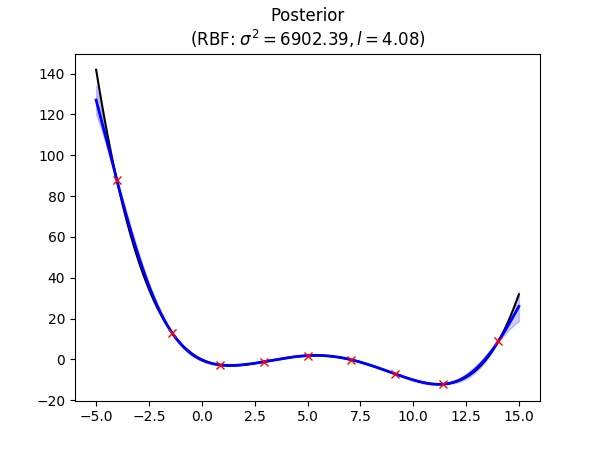

(1, 1000)
[8.83962312 1.40525719]
[6.90239075e+03 4.07657505e+00]


In [190]:
plt.figure(figsize=(4*1.5, 3*1.5))
plt.subplot(1, 1, 1)
kernel  = 1.0 * RBF(length_scale=1.0, length_scale_bounds=(1e-1, 1e4))
lim,res = [-5,20], 191
rng = np.random.RandomState(3)
# Training Data
x_fix = np.linspace(-5,15,1000)[np.newaxis, :]

data_set = np.load(os.path.join(MODEL_DIR_DATA,'Noise_free',r'True_domain_FIX_DoE_fix0.npy'))
x,y = data_set[0].T,data_set[1].T
# print(data_set[0].shape, data_set[1].shape)
plt.plot(x,y,'k',label=r'f(x)')
data_set = np.load(os.path.join(MODEL_DIR_DATA,'Noise_free',r'Train_Quadrature_hermite_PCE_doe0.npy'))
x_train    = data_set[0][0]
x_weight   = data_set[0][1]
y_train    = data_set[1]
zeta_train = data_set[2][0]
y_validate = data_set[3]
y_fix      = data_set[4]
# print(y_fix.shape)
plt.plot(x_train.T,y_train.T,'rx',zorder=9, label=r'Training Data')
print(x_fix.shape)



# Plot prior      
# Specify Gaussian Process
gp = GaussianProcessRegressor(kernel=kernel,n_restarts_optimizer=10)
#     y_mean, y_std = gp.predict(x_fix.T, return_std=True)
#     plt.plot(x_fix.T, y_mean, 'b-', zorder=9,label=r'Prediction')

#     plt.fill_between(np.squeeze(x_fix), y_mean - 1.96*y_std, y_mean + 1.96*y_std,
#                      color='b',alpha=0.2,edgecolor='None',label='95% confidence interval')

#     y_samples = gp.sample_y(X_[:, np.newaxis], 5)
#     plt.plot(X_, y_samples, '-.', lw=1,alpha=0.5)
# #     plt.ylim(-20,20)
# #     plt.fill_between(np.array([14,lim[1]]),np.array([20,20]),np.array([-20,-20]),'k',alpha=0.3)
#     plt.xlim(lim[0],lim[1])
# #     plt.ylim(-3, 3)
#     plt.xlabel("x")
#     plt.ylabel("y")
#     kernel_params = kernel.get_params()
#     kernel_str = "(RBF: $\sigma^2={:.2f}, l={:.2f}$)".format(kernel_params['k1__constant_value'],kernel_params['k2__length_scale'])
#     plt.title("Prior\n"+kernel_str)
#     plt.legend(loc=2)
#     plt.tight_layout()
#     plt.savefig("../Figures/GPR_RBF_prior.pdf")

#     # Plot posterior
#     plt.figure(figsize=(4*1.5, 3*1.5))
#     plt.subplot(1, 1, 1)
#     plt.plot(X_, y_, 'k', label=u'$f(x)=x\,\sin(x)$')
#     plt.plot(X_train,y_train, 'rs',markersize=4, label=r'Observations', zorder=9)
#     #  fit GP
gp.fit(x_train.T, np.squeeze(y_train))
y_mean, y_std = gp.predict(x_fix.T, return_std=True)

plt.plot(x_fix.T, y_mean, 'b', lw=2, zorder=8,label=r'Prediction') 
plt.fill_between(np.squeeze(x_fix), y_mean - 1.96*y_std, y_mean +  1.96*y_std,
                 color='b',alpha=0.2,edgecolor='None',
                 label='95% confidence interval')
kernel_params = gp.kernel_.get_params()
kernel_str = "(RBF: $\sigma^2={:.2f}, l={:.2f}$)".format(kernel_params['k1__constant_value'],kernel_params['k2__length_scale'])
plt.title("Posterior\n"+kernel_str)




#     plt.xlim(lim[0],lim[1])
#     plt.xlabel("x")
#     plt.ylabel("y")
#     kernel_params = gp.kernel_.get_params()
#     kernel_str = "(RBF: $\sigma^2={:.2f}, l={:.2f}$)".format(kernel_params['k1__constant_value'],kernel_params['k2__length_scale'])    

#     plt.title("Posterior\n"+kernel_str)
#     plt.legend()
#     plt.tight_layout()
#     plt.savefig("../Figures/GPR_RBF_posterior.pdf")
print(gp.kernel_.theta)
print(np.exp(gp.kernel_.theta))    

In [45]:
a = np.arange(10)
b = np.arange(10).reshape(10,1)
# a = a.reshape(b.shape)
print(a.shape,b.shape)
c = np.hstack((a.reshape(b.shape),b)).T
print(c.shape)

(10,) (10, 1)
(2, 10)


In [226]:
a =np.arange(10).reshape(2,5)
print(a.reshape(10,-1).shape)

(10, 1)


In [197]:
windowlength2plot       = 1000
metamodel_gp_y_mcs_ecdf = [] 
metamodel_gp_y_mcs_ecdf2plot = [] 
for r in range(10):
    data_set = np.load(os.path.join(MODEL_DIR_DATA,'Noise_free',r'True_MCS_R_DoE{}.npy'.format(r)))
    metamodel_gp_x_mcs    = data_set[0][0]
    metamodel_gp_mcs      = data_set[1]
    metamodel_gp_zeta_mcs = data_set[2][0]
    print(metamodel_gp_x_mcs.shape)
    metamodel_gp_y_samples= gp.sample_y(metamodel_gp_x_mcs[:10000,np.newaxis])
    iecdf = ECDF(np.squeeze(metamodel_gp_y_samples))
    metamodel_gp_y_mcs_ecdf.append(iecdf)
    
    indx1 = np.linspace(0,len(iecdf.x)-windowlength2plot, windowlength2plot, dtype=np.int32)
    indx2 = np.arange(indx1[-1]+1,len(iecdf.x),dtype=np.int32)
    indx  = np.hstack((indx1,indx2))
    metamodel_gp_y_mcs_ecdf2plot.append(Ecdf2plot(iecdf.x[indx],iecdf.y[indx]))
#     print(np.round(true_zeta_mcs[:5],4))
    
#     metamodel_zeta_mcs = data_set[2]
    






(10000000,)


KeyboardInterrupt: 

In [ ]:

# print(kernel_params)
# theta = [signal variance, length_scale, noise_variace, noise level]
res = 100
sigma_f        = kernel_params['k1__k1__constant_value']
length_scale   = np.logspace(-3,3,res)
noise_variance = kernel_params['k2__k1__constant_value']
noise_level    = np.logspace(-3,3,res)
# theta1 = np.logspace(-1,1,10)
Theta1, Theta3 = np.meshgrid(length_scale, noise_level)
print(Theta1.shape)
# LML = np.array([[gp.log_marginal_likelihood(np.log([Theta1[i, j], Theta3[i, j]]))
#     for i in range(Theta1.shape[0])] for j in range(Theta1.shape[1])])
LML = np.array([[gp.log_marginal_likelihood(np.log([sigma_f, Theta1[i, j], noise_variance, Theta3[i, j]]))
    for i in range(Theta1.shape[0])] for j in range(Theta1.shape[1])])
print(LML.shape)
vmin, vmax = (-LML).min(), (-LML).max()
vmax = 50
level = np.around(np.logspace(np.log10(vmin), np.log10(vmax), 50), decimals=1)

plt.figure(figsize=(4*1.5, 3*1.5))
plt.contour(Theta1, Theta3, -LML,levels=level,norm=LogNorm(vmin=vmin,vmax=vmax))
theta_opt = np.exp(gp.kernel_.theta)
plt.plot(theta_opt[1],theta_opt[3],'r+')
plt.colorbar()
plt.xscale("log")
plt.yscale("log")
plt.xlabel(r"Length-scale $l$")
plt.ylabel(r"Noise-level $\sigma_n$")
plt.title(r"$-\log(p(y|X,\theta,\mathcal{H}_i))$")
plt.savefig("../Figures/GPR_RBF_WN_LML_noise_level_length_scale.pdf")
plt.tight_layout()



In [167]:
a = y_mean.T - 1.96*y_std.T
print(a.shape)

(1, 1000)


In [5]:
pf = 1e-4
x_mu, x_sigma = 5,2
dist_x    = cp.Normal(x_mu, x_sigma) # normal mean = 0, normal std=0.25
dist_zeta = cp.Normal()
x_cr      = dist_x.inv(1-pf) ## Critical value corresponding to failure prob pf
nstd_from_mean = np.ceil((x_cr-x_mu)/x_sigma)+1
x = np.linspace(x_mu-nstd_from_mean*x_sigma, x_mu+nstd_from_mean*x_sigma,1000)
y_mean = f(x)
error = abs(y_mean)/5

# plt.plot([x_cr,x_cr], [0,f([x_cr])])
# plt.plot([2*x_mu-x_cr,2*x_mu-x_cr], [0,f([x_cr])])
# print(x_cr,nstd_from_mean)
# print(training_x.shape,weight_xy.shape,training_y.shape)

NameError: name 'f' is not defined

In [44]:
plt.savefig(os.path.join(MODEL_DIR_FIGURE, r'ECDF_Bench4.pdf'))

<IPython.core.display.Javascript object>


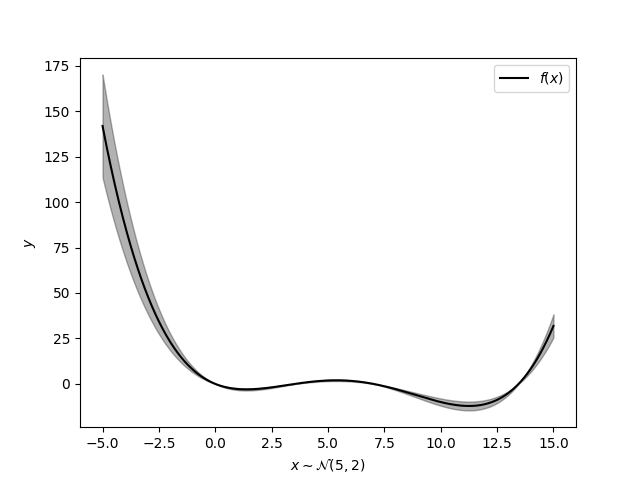

In [21]:
plt.figure()
plt.plot(x,y_mean,'k',label=r'$f(x)$')
plt.fill_between(x, y_mean+error,y_mean-error,color='k',alpha=0.3)
# print(x.shape,y_true.shape)
# data_set = np.load(os.path.join(MODEL_DIR_DATA,r'Quadrature_hermite_doe0.npy'))
# training_zeta = data_set[3]
# training_x = data_set[0]
# weights_xy = data_set[1]
# y_obs_mean = f(training_x)

# error_sigma= abs(y_obs_mean)/5
# error_type = ErrorType('normal',[0,error_sigma.T])
# y_norm     = f(training_x, error_type)

# error_type = ErrorType('weibull',[1,0.3])
# y_weib = f(training_x, error_type)
# error_type = ErrorType('gumbel',[1,0.3])
# y_gumb = f(training_x, error_type)
# plt.plot(training_x.T,y_obs_mean, 'kx')#,label=r'Observations ($\epsilon\sim p(\epsilon))$')
# plt.plot(training_x.T,y_norm, 'rs',label=r'Observations ($\epsilon\sim p(\epsilon))$')
# plt.plot(training_x.T,y_weib, 'bs',label=r'weibull')
# plt.plot(training_x.T,y_gumb, 'gs',label=r'gumble')
plt.xlabel(r'$x \sim \mathcal{N}(5,2)$')
plt.ylabel(r'$y$')
plt.legend()

In [8]:
np.random.seed(100)
nsamples  = int(100*1/pf)

x_samples = np.random.normal(x_mu,x_sigma,nsamples)
y_samples = f(x_samples)
ecdf_y    = ECDF(y_samples)

error_sigma    = abs(y_samples)/5
error_type     = ErrorType('normal',[0,error_sigma.T])
y_norm_samples = f(x_samples, error_type)
ecdf_y_norm    = ECDF(y_norm_samples)

<IPython.core.display.Javascript object>


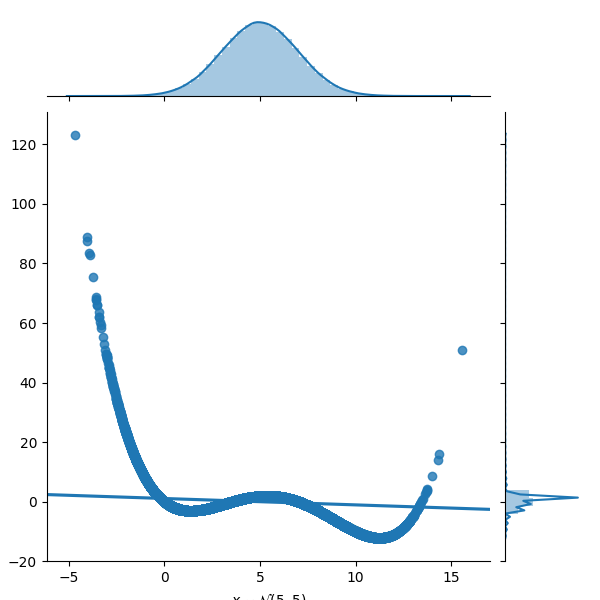

Text(37.722222222222214, 0.5, '$y$')

In [277]:
sns.jointplot(x_samples, y_samples,kind='reg')
plt.xlabel(r'$x \sim \mathcal{N}(5,5)$')
plt.ylabel(r'$y$')

<IPython.core.display.Javascript object>


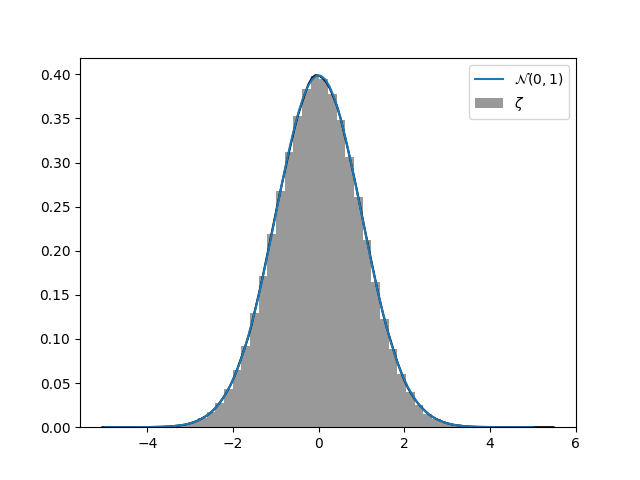

In [10]:
zeta_samples = dist_zeta.inv(dist_x.cdf(x_samples))
plt.figure()
sns.distplot(zeta_samples,color='k',label=r'$\zeta$');
zeta = np.linspace(-5,5,100)
plt.plot(zeta,dist_zeta.pdf(zeta),label=r'$\mathcal{N}(0,1)$')
plt.legend()


In [13]:
orthpoly_orders = np.arange(1,10)
training_y   = y_obs_mean
metamodels   = []
f_orth_coeffs= []
f_preds      = []

print(training_zeta.shape, weights_xy.shape, training_y.shape)
print(zeta_samples.shape)
for iorthpoly_order in orthpoly_orders:
#     print(orthpoly_order_i)
    orth_poly, norms = cp.orth_ttr(iorthpoly_order, dist_zeta, retall=True)
    f_hat, coeffs = cp.fit_quadrature(orth_poly, training_zeta, weights_xy, np.squeeze(training_y), retall=True,norms=norms)
    f_preds.append(f_hat(zeta_samples))
    metamodels.append(f_hat)
    f_orth_coeffs.append(coeffs)


(1, 9) (9,) (9, 1)
(1000000,)


9


<IPython.core.display.Javascript object>


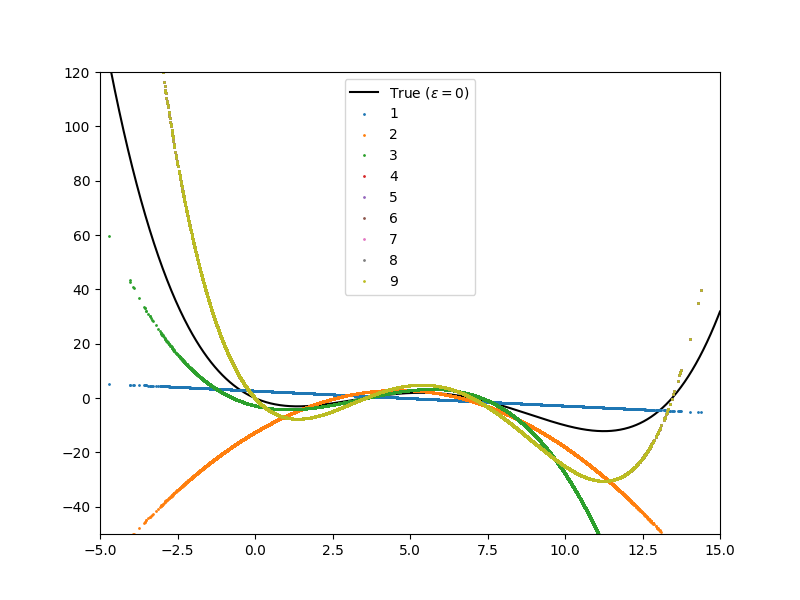

(-50, 120)

In [15]:
print(len(f_preds))
fig1 = plt.figure(figsize=(8,6))
ax1  = fig1.add_subplot(1,1,1)
ax1.plot(x,y_mean,'k',label=r'True $(\epsilon=0)$')
# ax1.fill_between(x, y_mean+error,y_mean-error,color='k',alpha=0.3)
iorder = 1
for f_pred in f_preds:
#     lists = sorted(zip(*[x_samples, f_pred]))
#     x, y = list(zip(*lists))
    ax1.plot(x_samples, f_pred, 'o', markersize=1,label='{}'.format(iorder))
    iorder += 1
ax1.legend()
ax1.set_xlim(-5,15)
ax1.set_ylim(-50,120)

<IPython.core.display.Javascript object>


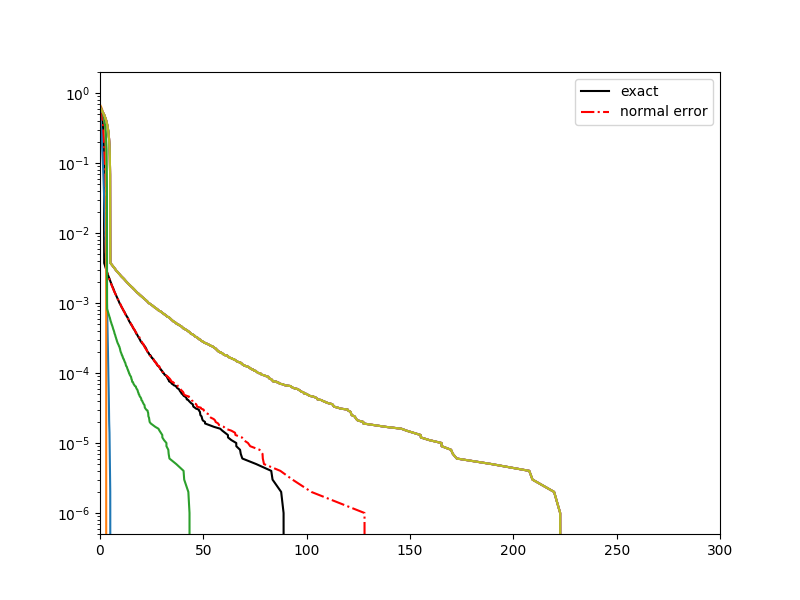

In [360]:
# print(f_preds)
ecdf_y_pce = [ECDF(f_pred) for f_pred in f_preds]
plt.figure(figsize=(8,6))
plt.semilogy(ecdf_y.x,1-ecdf_y.y, 'k',label=r'exact')
plt.semilogy(ecdf_y_norm.x,1-ecdf_y_norm.y, '-.r',label=r'normal error')
# print(ecdf_y_pce)
for iecdf in ecdf_y_pce:
    plt.semilogy(iecdf.x, 1-iecdf.y)
plt.xlim(0,300)
plt.legend()

### 2. Periodic function 
\begin{equation}
f=x \sin(x) + \epsilon,\quad x \sim \mathcal{N}\,(5,5), \quad \epsilon \sim p(\epsilon)
\end{equation}


In [104]:
def bench1(x, error_type=ErrorType()):
    x = np.array(x)           
    error = gen_error(len(x), error_type)
    print(error_type.name)
    y0 = x * np.sin(x)
    y = y0 + error
    return y.T

In [105]:
x = np.linspace(-5,20,191)
y_true = bench1(x)
print(x.shape,y_true.shape)

None
(191,) (191,)


In [106]:
error_type = ErrorType('normal',[1,1])
y_norm = bench1(x,error_type)
error_type = ErrorType('weibull',[1,1])
y_weib = bench1(x,error_type)
error_type = ErrorType('gumbel',[1,1])
y_gumb = bench1(x,error_type)

normal
weibull
gumbel


<IPython.core.display.Javascript object>


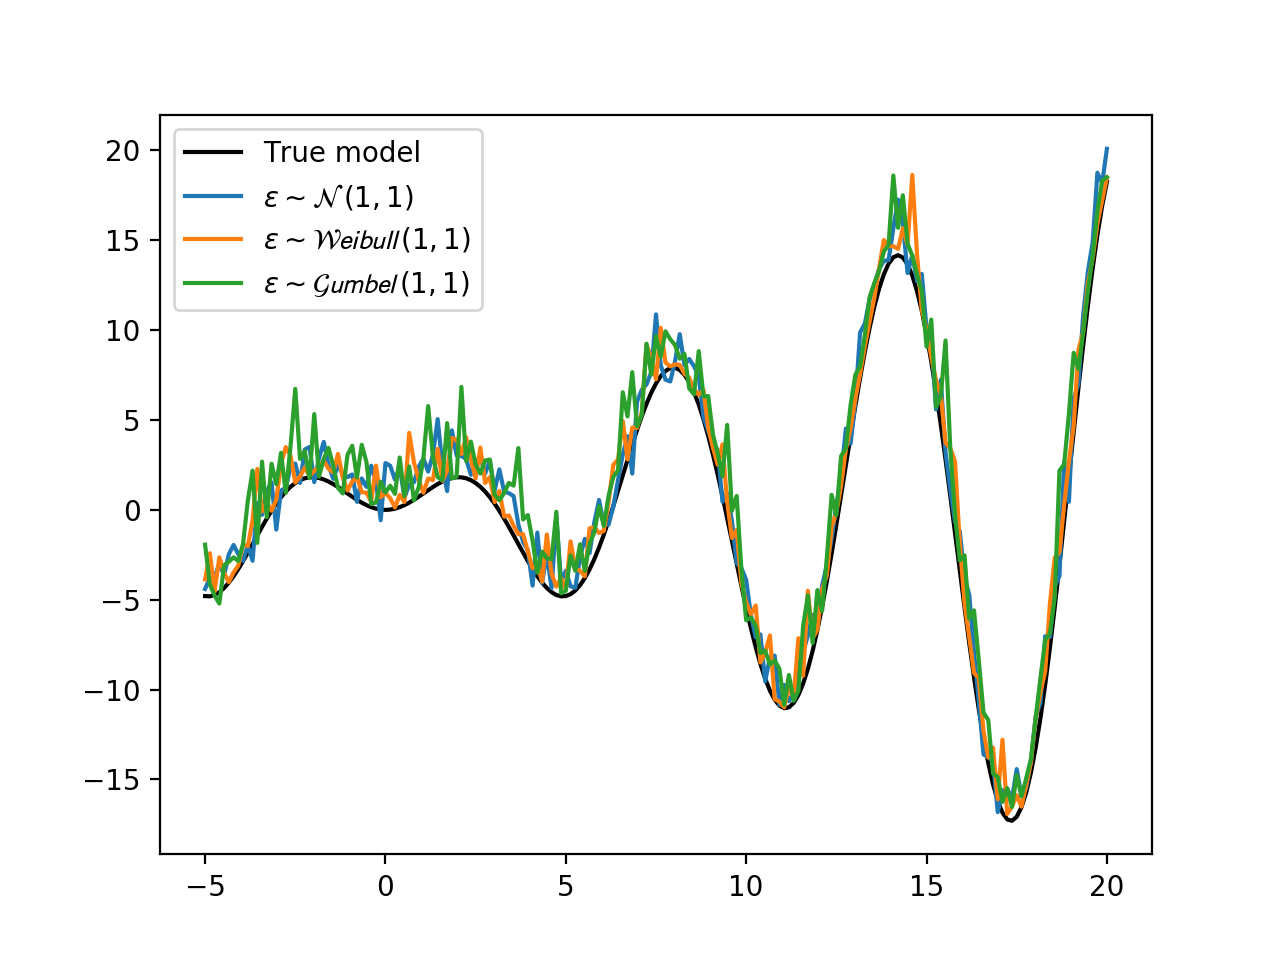

In [107]:
plt.figure()
plt.plot(x,y_true,'k',label='True model')
plt.plot(x,y_norm,label=r'$\epsilon \sim \mathcal{N}\,(1,1)$')
plt.plot(x,y_weib,label=r'$\epsilon \sim \mathcal{Weibull}\,(1,1)$')
plt.plot(x,y_gumb,label=r'$\epsilon \sim \mathcal{Gumbel}\,(1,1)$')
plt.legend()

In [122]:
nsamples = int(1e6)
np.random.seed(100)
x_samples = np.random.normal(5,5,nsamples)
y_samples = bench1(x_samples)
ecdf      = ECDF(y_samples)

error_type     = ErrorType('normal',[1,1])
y_norm_samples = bench1(x_sampels,error_type)
ecdf_norm      = ECDF(y_norm_samples)

error_type     = ErrorType('weibull',[1,1])
y_weib_samples = bench1(x_sampels,error_type)
ecdf_weib      = ECDF(y_weib_samples)

error_type     = ErrorType('gumbel',[1,1])
y_gumb_samples = bench1(x_sampels,error_type)
ecdf_gumb      = ECDF(y_gumb_samples)

None
normal
weibull
gumbel


<IPython.core.display.Javascript object>


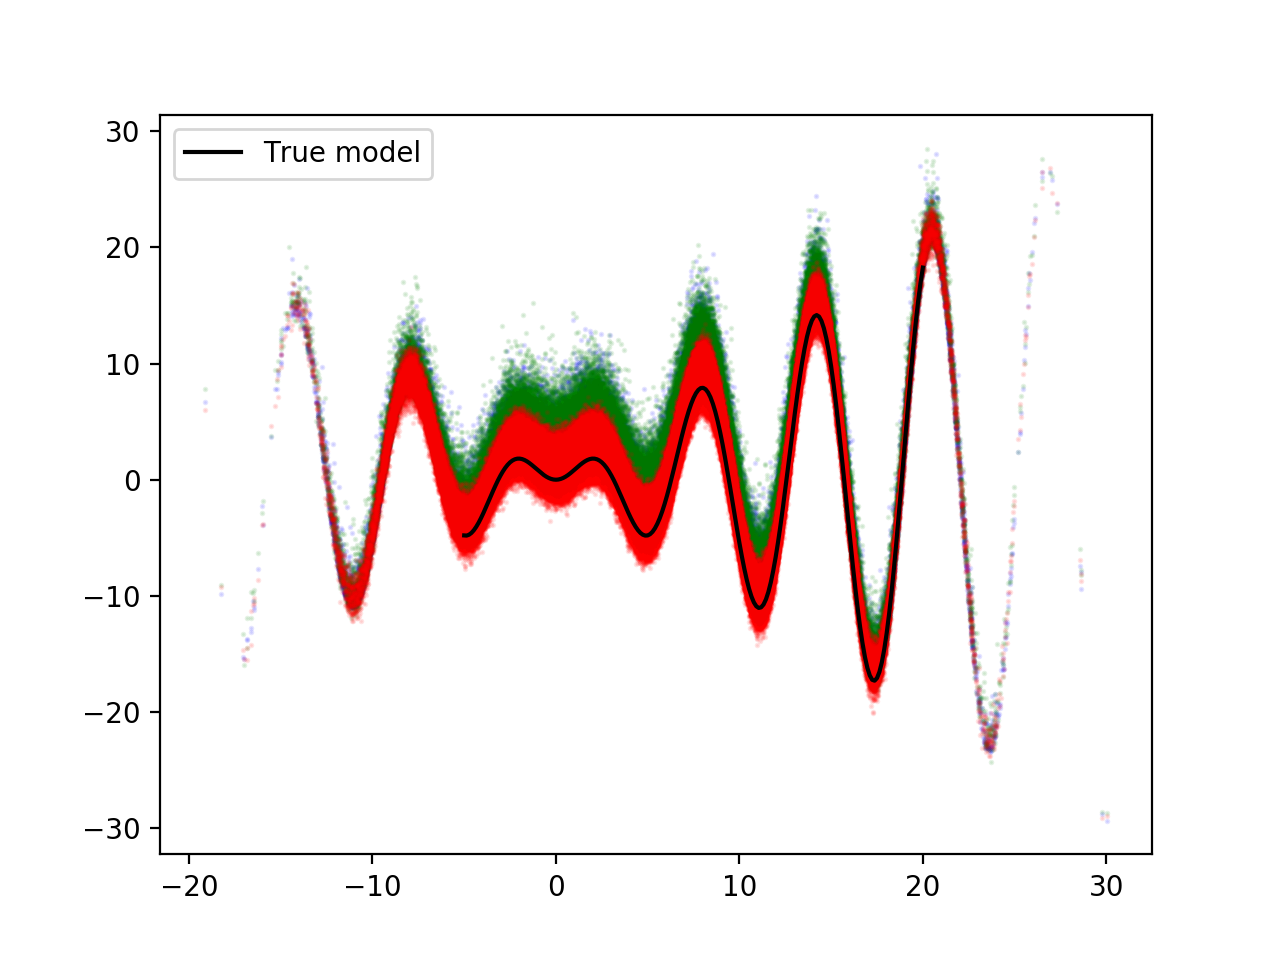

In [123]:
plt.figure()
plt.plot(x,y_true,'k',label='True model',zorder=9)
plt.plot(x_sampels,y_norm_samples,'ro',markersize=1,alpha=0.1,zorder=8)
plt.plot(x_sampels,y_weib_samples,'bo',markersize=1,alpha=0.1)
plt.plot(x_sampels,y_gumb_samples,'go',markersize=1,alpha=0.1)
plt.legend()

<IPython.core.display.Javascript object>


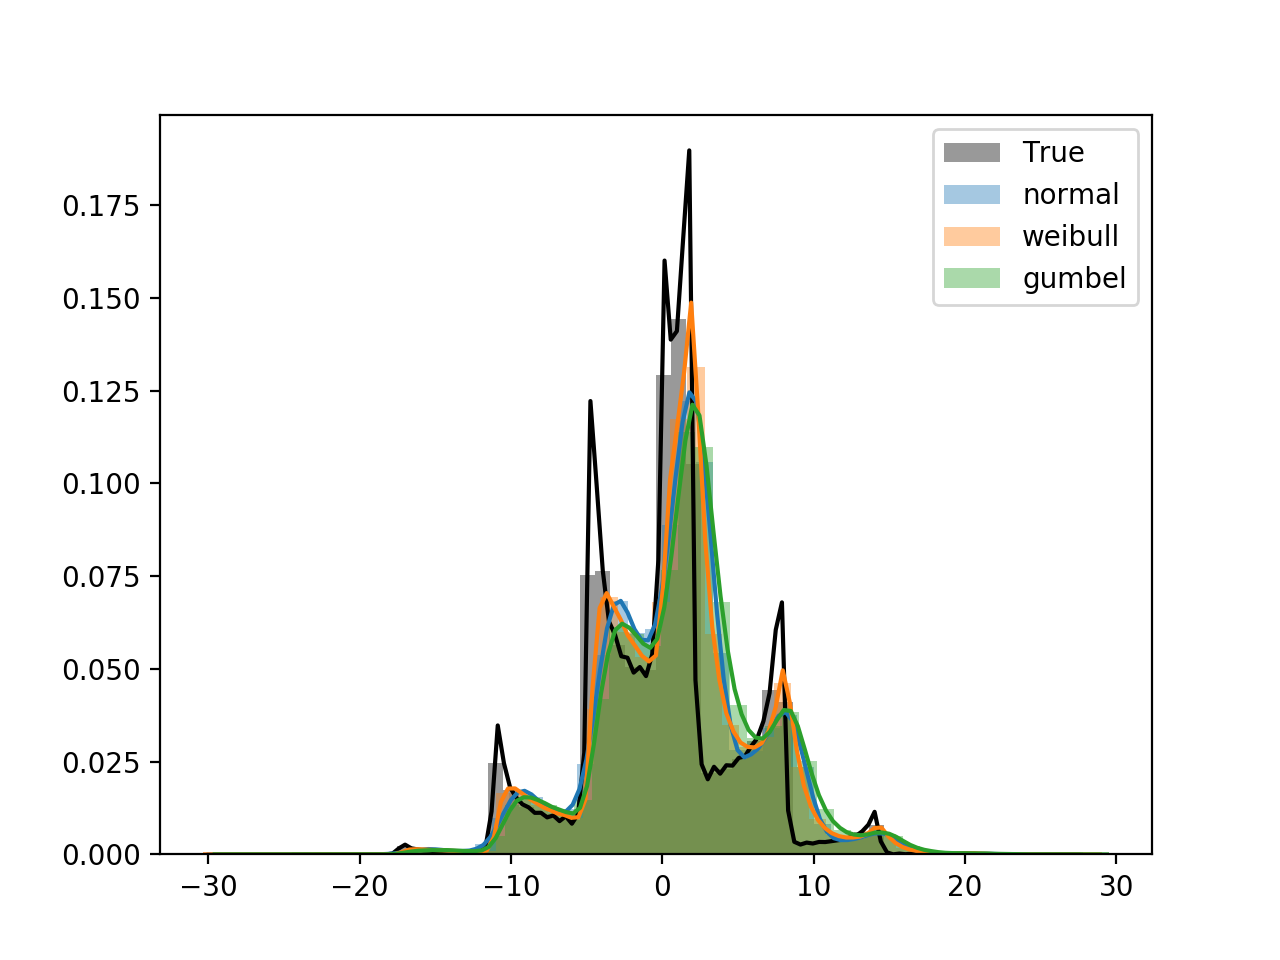

In [129]:
import seaborn as sns
# hist_true = np.histogram(y_samples)
# hist_norm = np.histogram(y_norm_samples)
# hist_weib = np.histogram(y_weib_samples)
# hist_gumb = np.histogram(y_gumb_samples)

plt.figure()
sns.distplot(y_samples,color='k',label='True');
sns.distplot(y_norm_samples,label='normal');
sns.distplot(y_weib_samples,label='weibull');
sns.distplot(y_gumb_samples,label='gumbel');
plt.legend()
# plt.hist(y_samples,bins=30,color='k',alpha=0.1)
# plt.hist(y_norm_samples,bins=30,color='r',alpha=0.5)
# plt.hist(y_weib_samples,bins=30,color='b',alpha=0.5)
# plt.hist(y_gumb_samples,bins=30,color='g',alpha=0.5)

<IPython.core.display.Javascript object>


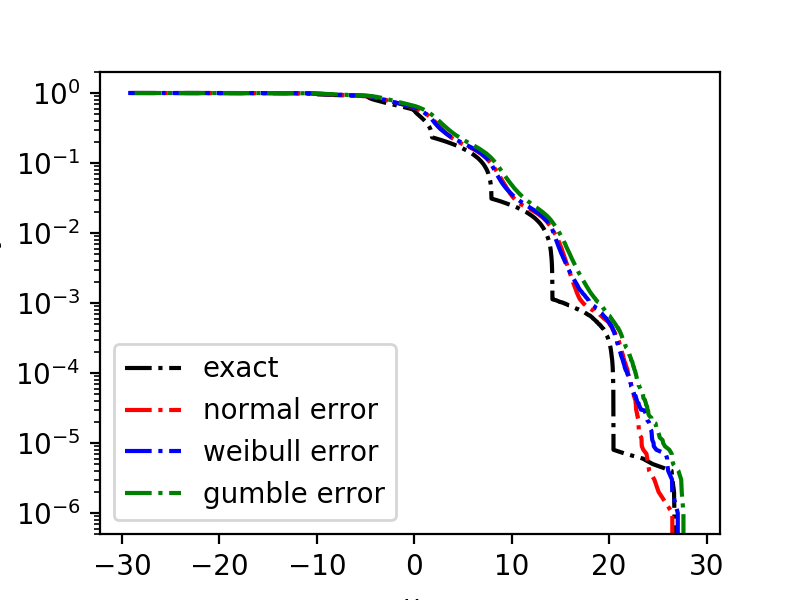

In [124]:
plt.figure(figsize=(4,3))
plt.semilogy(ecdf.x,1-ecdf.y, '-.k',label=r'exact')
plt.semilogy(ecdf_norm.x,1-ecdf_norm.y, '-.r',label=r'normal error')
plt.semilogy(ecdf_weib.x,1-ecdf_weib.y, '-.b',label=r'weibull error')
plt.semilogy(ecdf_gumb.x,1-ecdf_gumb.y, '-.g',label=r'gumble error')
# for j,i in enumerate(np.arange(0,len(x1_ecdf_hat),2)):
#     axes[1,0].semilogy(x1_ecdf_hat[i].x,1-x1_ecdf_hat[i].y,linestyle=pltlinestyles[j],color=pltcolors[0], label=r'${}$-order'.format(ordinal(i+1)))
#     axes[1,0].semilogy(x2_ecdf_hat[i].x,1-x2_ecdf_hat[i].y,linestyle=pltlinestyles[j],color=pltcolors[1])#, label=r'${}$-order'.format(i+1)

plt.xlabel(r'$u$')
plt.ylabel(r'$Probability$')
# plt.title(r'Exceedence probability $P(X>x_0)$')
# plt.ylim((10/nsamples,1))
plt.legend()
